# DLOps Assignment - 3: Trasnformer

    Ayush Abrol B20AI052

---

## Perform image classification on selected classes of CIFAR-10 dataset using transformer model:

### Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import warnings
warnings.filterwarnings("ignore")

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Transformations

In [2]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Dataset and Dataloader

In [3]:
train_loader = torch.utils.data.DataLoader(  
    datasets.CIFAR10('data', train=True, download=True,
                        transform=train_transform),
    batch_size=32, shuffle=True) # 128 is the batch size

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=test_transform),
    batch_size=32, shuffle=False)  

Files already downloaded and verified


In [37]:
X_train = train_loader.dataset.data # 50000 images
y_train = np.array(train_loader.dataset.targets) # 50000 labels
X_test = test_loader.dataset.data # 10000 images
y_test = np.array(test_loader.dataset.targets) # 10000 labels

print("Train data shape: ", X_train.shape) 
print("Test data shape: ", X_test.shape)

print("Train data labels shape: ", y_train.shape)
print("Test data labels shape: ", y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Train data labels shape:  (50000,)
Test data labels shape:  (10000,)


### Classes

In [38]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

### Selected classes

In [39]:
odd_classes = [0, 2, 4, 6, 8]
X_train_odd = X_train[np.isin(y_train, odd_classes)]
y_train_odd = y_train[np.isin(y_train, odd_classes)]
X_test_odd = X_test[np.isin(y_test, odd_classes)]
y_test_odd = y_test[np.isin(y_test, odd_classes)]

print("Train data shape: ", X_train_odd.shape)
print("Test data shape: ", X_test_odd.shape)

print("Train data labels shape: ", y_train_odd.shape)
print("Test data labels shape: ", y_test_odd.shape)

Train data shape:  (25000, 32, 32, 3)
Test data shape:  (5000, 32, 32, 3)
Train data labels shape:  (25000,)
Test data labels shape:  (5000,)


In [40]:
# Change the labels from 0, 2, 4, 6, 8 to 0, 1, 2, 3, 4
y_train_odd = y_train_odd / 2
y_test_odd = y_test_odd / 2
classes = {0: 'airplane', 1: 'bird', 2: 'deer', 3: 'frog', 4: 'ship'}

### Visualization of selected classes

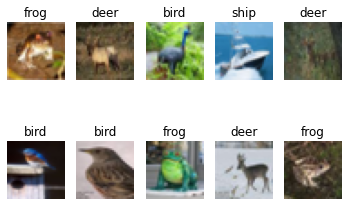

In [41]:
for i in range(10): 
    plt.subplot(2,5,i+1) 
    plt.imshow(X_train_odd[i]) # Displaying the image
    plt.title(classes[y_train_odd[i]]) # Displaying the label
    plt.axis('off')

### Creating Dataloader compatible with PyTorch

In [42]:
def create_dataloader(x_train, y_train, x_test, y_test):
    x_train, x_test, y_train, y_test = torch.Tensor(x_train).permute(0, 3, 1, 2), torch.Tensor(x_test).permute(0, 3, 1, 2), torch.Tensor(y_train), torch.Tensor(y_test)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle = True)

    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle = False)

    return trainloader, testloader

trainloader, testloader = create_dataloader(X_train_odd, y_train_odd, X_test_odd, y_test_odd)

torch.Size([25000, 3, 32, 32]) torch.Size([25000]) torch.Size([5000, 3, 32, 32]) torch.Size([5000])


### Setting up device to use GPU

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device  

device(type='cuda', index=0)

### Using cosine positional embedding with six encoders and decoder layers with eight heads. Using relu activation in the intermediate layers.

In [44]:
def patchify(images, n_patches): 
    n, c, h, w = images.shape # n = batch size, c = channels, h = height, w = width

    assert h == w, "Patchify method is implemented for square images only" # Check if the image is square

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2) # Initialize the patches tensor
    patch_size = h // n_patches # Size of each patch

    for idx, image in enumerate(images): # Loop over the images in the batch
        for i in range(n_patches):   # Loop over the rows of the image
            for j in range(n_patches): # Loop over the columns of the image
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size] # Extract the patch
                patches[idx, i * n_patches + j] = patch.flatten() # Flatten the patch and store it in the patches tensor
    return patches

In [45]:
def get_positional_embeddings(sequence_length, d): # sequence_length = length of the sequence, d = embedding dimension
    result = torch.ones(sequence_length, d) # Initialize the result tensor
    for i in range(sequence_length): # Loop over the sequence length
        for j in range(d): # Loop over the embedding dimension
            result[i][j] = np.cos(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d))) # Calculate the positional embedding
    return result

In [46]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2): # d = dimension of the input, n_heads = number of heads
        super(MyMSA, self).__init__() # Initialize the parent class
        self.d = d # Store the dimension of the input
        self.n_heads = n_heads # Store the number of heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads" # Check if the dimension can be divided into the number of heads

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)]) # Initialize the q mappings
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)]) # Initialize the k mappings
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)]) # Initialize the v mappings
        self.d_head = d_head # Store the dimension of each head
        self.softmax = nn.Softmax(dim=-1) # Initialize the softmax layer

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = [] # Initialize the result list 
        for sequence in sequences: # Loop over the sequences in the batch
            seq_result = [] # Initialize the sequence result list
            for head in range(self.n_heads): # Loop over the heads
                q_mapping = self.q_mappings[head] # Get the q mapping for the current head
                k_mapping = self.k_mappings[head] # Get the k mapping for the current head
                v_mapping = self.v_mappings[head] # Get the v mapping for the current head

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head] # Extract the current head from the sequence
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq) # Apply the mappings to the sequence

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5)) # Calculate the attention
                seq_result.append(attention @ v) # Calculate the sequence result
            result.append(torch.hstack(seq_result)) # Concatenate the sequence result and store it in the result list
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result]) # Concatenate the result list and return it

In [47]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.ReLU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [63]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Cosine Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [52]:
model = MyViT((3, 32, 32), n_patches=8, n_blocks=2, hidden_d=6, n_heads=8, out_d=5)
model.to(device)

MyViT(
  (linear_mapper): Linear(in_features=48, out_features=6, bias=True)
  (blocks): ModuleList(
    (0): MyViTBlock(
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (k_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (v_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=6, out_features=24, bias=True)
        (1): ReLU()
        (2): Linear(in_features=24, out_features=6, bias=

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [54]:
train_loss = []
train_acc = []
num_epochs = 10

In [55]:
def train(model, trainloader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_acc += (predicted == labels).sum().item()
        train_loss.append(running_loss / len(trainloader))
        train_acc.append(running_acc / len(trainloader.dataset))
        print("Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%".format(epoch+1, running_loss / len(trainloader), 100 * running_acc / len(trainloader.dataset)))
    return model, train_loss, train_acc

In [56]:
torch.cuda.empty_cache()

In [57]:
print("Training started...")
model, train_loss, train_acc = train(model, trainloader, optimizer, criterion, num_epochs)
print("Training finished!")

Training started...
Epoch: 1, Loss: 1.5471, Accuracy: 31.45%
Epoch: 2, Loss: 1.4856, Accuracy: 38.61%
Epoch: 3, Loss: 1.4732, Accuracy: 40.59%
Epoch: 4, Loss: 1.4630, Accuracy: 41.65%
Epoch: 5, Loss: 1.4554, Accuracy: 42.62%
Epoch: 6, Loss: 1.4512, Accuracy: 42.96%
Epoch: 7, Loss: 1.4469, Accuracy: 43.12%
Epoch: 8, Loss: 1.4422, Accuracy: 44.07%
Epoch: 9, Loss: 1.4387, Accuracy: 44.51%
Epoch: 10, Loss: 1.4333, Accuracy: 44.96%
Training finished!


In [58]:
# Saving the model
torch.save(model.state_dict(), "model_pos_embeddings.pth")

In [59]:
# Save the loss and accuracy arrays
np.save("train_loss_pos_embeddings.npy", np.array(train_loss))
np.save("train_acc_pos_embeddings.npy", np.array(train_acc))

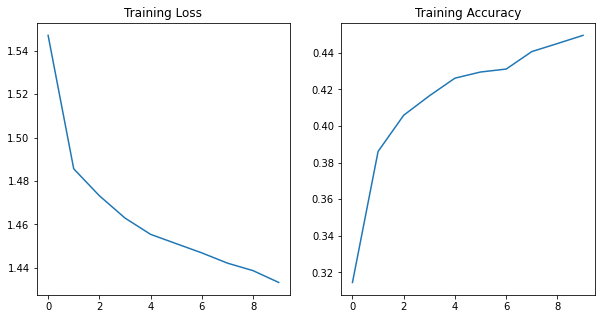

In [60]:
# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.title("Training Accuracy")
plt.show()

In [84]:
# Testing the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 5000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 5000 test images: 45 %


### Using learnable positional encoding with four encoder and decoder layers with six heads. Using relu activation in the intermediate layers.

In [85]:
from einops import rearrange
def get_learnable_positional_encodings(sequence_length, d):
    heads = None
    scale = d ** -0.5
    shared_heads = heads if heads is not None else True
    if shared_heads:
        rel_pos_emb = nn.Parameter(torch.randn(2 * sequence_length - 1, d) * scale)
    else:
        rel_pos_emb = nn.Parameter(torch.randn(heads, 2 * sequence_length - 1, d) * scale)
    return rel_pos_emb

In [86]:
class MyViT_pos_encode(nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT_pos_encode, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Learnable Positional Encoding
        self.register_buffer('positional_encodings', get_learnable_positional_encodings(n_patches ** 2 + 1, hidden_d), persistent=False)
        # 3) Cosine Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [87]:
model_pos_encode = MyViT_pos_encode((3, 32, 32), n_patches=8, n_blocks=2, hidden_d=6, n_heads=6, out_d=5).to(device)
model_pos_encode

MyViT_pos_encode(
  (linear_mapper): Linear(in_features=48, out_features=8, bias=True)
  (blocks): ModuleList(
    (0): MyViTBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (k_mappings): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (v_mappings): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=8, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_featur

In [88]:
optimizer_encode = optim.Adam(model_pos_encode.parameters(), lr=0.001)
criterion_encode = nn.CrossEntropyLoss()

In [89]:
train_loss_encode = []
train_acc_encode = []

In [90]:
print("Training started...")
model_pos_encode, train_loss_encode, train_acc_encode = train(model_pos_encode, trainloader, optimizer_encode, criterion_encode, num_epochs)
print("Training finished!")

Training started...
Epoch: 1, Loss: 1.5320, Accuracy: 33.40%
Epoch: 2, Loss: 1.4871, Accuracy: 37.84%
Epoch: 3, Loss: 1.4714, Accuracy: 40.30%
Epoch: 4, Loss: 1.4554, Accuracy: 42.44%
Epoch: 5, Loss: 1.4434, Accuracy: 43.80%
Epoch: 6, Loss: 1.4403, Accuracy: 43.89%
Epoch: 7, Loss: 1.4299, Accuracy: 45.08%
Epoch: 8, Loss: 1.4243, Accuracy: 45.50%
Epoch: 9, Loss: 1.4162, Accuracy: 46.40%
Epoch: 10, Loss: 1.4137, Accuracy: 46.93%
Training finished!


In [91]:
# Saving the model
torch.save(model_pos_encode.state_dict(), "model_pos_encode.pth")

In [92]:
# Save the loss and accuracy arrays
np.save("train_loss_pos_encode.npy", np.array(train_loss_encode))
np.save("train_acc_pos_encode.npy", np.array(train_acc_encode))

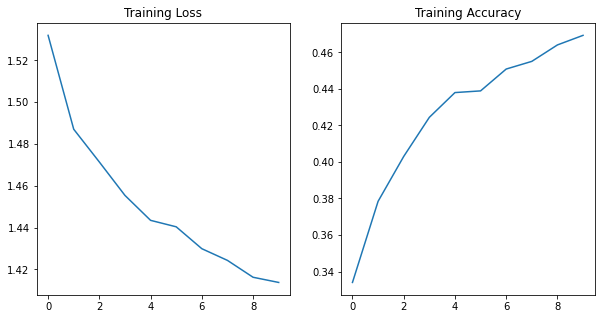

In [102]:
# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_encode)
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(train_acc_encode)
plt.title("Training Accuracy")
plt.show()

In [94]:
# Testing the model
model_pos_encode.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_pos_encode(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 5000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 5000 test images: 46 %


### For both the methods, changing the activation function to tanh in the intermediate layers.

 - Using cosine positional embedding with six encoders and decoder layers with eight heads. Using tanh activation in the intermediate layers.

In [61]:
class MyViTBlock_tanh(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock_tanh, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.Tanh(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [64]:
class MyViT_tanh(nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT_tanh, self).__init__()
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Cosine Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock_tanh(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [65]:
model_pos_embeddings_tanh = MyViT_tanh(chw=(3, 32, 32), n_patches=8, n_blocks=2, hidden_d=6, n_heads=8, out_d=5).to(device)
model_pos_embeddings_tanh

MyViT_tanh(
  (linear_mapper): Linear(in_features=48, out_features=6, bias=True)
  (blocks): ModuleList(
    (0): MyViTBlock_tanh(
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (k_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (v_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=6, out_features=24, bias=True)
        (1): Tanh()
        (2): Linear(in_features=24, out_feature

In [66]:
optimizer_pos_embeddings_tanh = torch.optim.Adam(model_pos_embeddings_tanh.parameters(), lr=0.001)
criterion_pos_embeddings_tanh = nn.CrossEntropyLoss()

In [67]:
train_loss_pos_embeddings_tanh = []
train_acc_pos_embeddings_tanh = []

In [68]:
torch.cuda.empty_cache()

In [69]:
print("Training started...")
model_pos_embeddings_tanh, train_loss_pos_embeddings_tanh, train_acc_pos_embeddings_tanh = train(model_pos_embeddings_tanh, trainloader, optimizer_pos_embeddings_tanh, criterion_pos_embeddings_tanh, num_epochs)
print("Training finished!")

Training started...
Epoch: 1, Loss: 1.5317, Accuracy: 34.37%
Epoch: 2, Loss: 1.4927, Accuracy: 37.34%
Epoch: 3, Loss: 1.4747, Accuracy: 40.69%
Epoch: 4, Loss: 1.4580, Accuracy: 42.26%
Epoch: 5, Loss: 1.4445, Accuracy: 43.78%
Epoch: 6, Loss: 1.4353, Accuracy: 44.94%
Epoch: 7, Loss: 1.4252, Accuracy: 46.01%
Epoch: 8, Loss: 1.4239, Accuracy: 45.98%
Epoch: 9, Loss: 1.4202, Accuracy: 46.35%
Epoch: 10, Loss: 1.4132, Accuracy: 47.07%
Training finished!


In [70]:
# Saving the model
torch.save(model_pos_embeddings_tanh.state_dict(), "model_pos_embeddings_tanh.pth")

# Save the loss and accuracy arrays
np.save("train_loss_pos_embeddings_tanh.npy", np.array(train_loss_pos_embeddings_tanh))
np.save("train_acc_pos_embeddings_tanh.npy", np.array(train_acc_pos_embeddings_tanh))

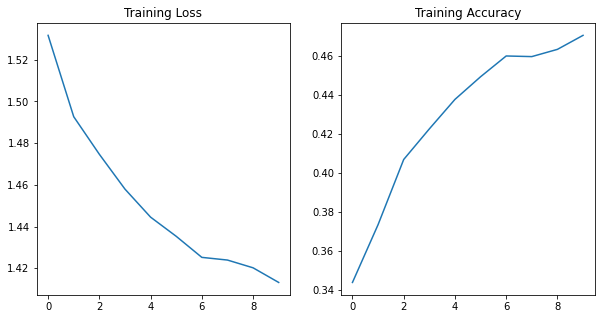

In [83]:
# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_pos_embeddings_tanh)
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(train_acc_pos_embeddings_tanh)
plt.title("Training Accuracy")
plt.show()

In [95]:
# Testing the model
model_pos_embeddings_tanh.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_pos_embeddings_tanh(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 5000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 5000 test images: 46 %


 - Using learnable positional encoding with four encoder and decoder layers with six heads. Using tanh activation in the intermediate layers.

In [96]:
class MyViTBlock_tanh(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock_tanh, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.Tanh(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [97]:
class MyViT_tanh(nn.Module):
    def __init__(self, chw, n_patches=8, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT_tanh, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Cosine Positional embedding
        self.register_buffer('positional_embeddings', get_learnable_positional_encodings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock_tanh(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [98]:
model_pos_encode_tanh = MyViT_tanh(chw=(3, 32, 32), n_patches=8, n_blocks=2, hidden_d=6, n_heads=2, out_d=5).to(device)
model_pos_encode_tanh

MyViT_tanh(
  (linear_mapper): Linear(in_features=48, out_features=6, bias=True)
  (blocks): ModuleList(
    (0): MyViTBlock_tanh(
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (k_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (v_mappings): ModuleList(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Linear(in_features=3, out_features=3, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=6, out_features=24, bias=True)
        (1): Tanh()
        (2): Linear(in_features=24, out_feature

In [99]:
optimizer_pos_encode_tanh = optim.Adam(model_pos_encode_tanh.parameters(), lr=0.001)
criterion_pos_encode_tanh = nn.CrossEntropyLoss()

In [100]:
train_loss_pos_encode_tanh = []
train_acc_pos_encode_tanh = []

In [104]:
print("Training started...")
model_pos_encode_tanh, train_loss_pos_encode_tanh, train_acc_pos_encode_tanh = train(model_pos_encode_tanh, trainloader, optimizer_pos_encode_tanh, criterion_pos_encode_tanh, num_epochs)
print("Training finished!")

Training started...
Epoch: 1, Loss: 1.5216, Accuracy: 34.81%
Epoch: 2, Loss: 1.4942, Accuracy: 37.78%
Epoch: 3, Loss: 1.4694, Accuracy: 40.94%
Epoch: 4, Loss: 1.4546, Accuracy: 42.73%
Epoch: 5, Loss: 1.4437, Accuracy: 43.90%
Epoch: 6, Loss: 1.4449, Accuracy: 43.75%
Epoch: 7, Loss: 1.4338, Accuracy: 44.88%
Epoch: 8, Loss: 1.4295, Accuracy: 45.78%
Epoch: 9, Loss: 1.4203, Accuracy: 46.76%
Epoch: 10, Loss: 1.4168, Accuracy: 47.19%
Training finished!


In [105]:
torch.save(model_pos_encode_tanh.state_dict(), "model_pos_encode_tanh.pth")

In [106]:
np.save("train_loss_pos_encode_tanh.npy", np.array(train_loss_pos_encode_tanh))
np.save("train_acc_pos_encode_tanh.npy", np.array(train_acc_pos_encode_tanh))

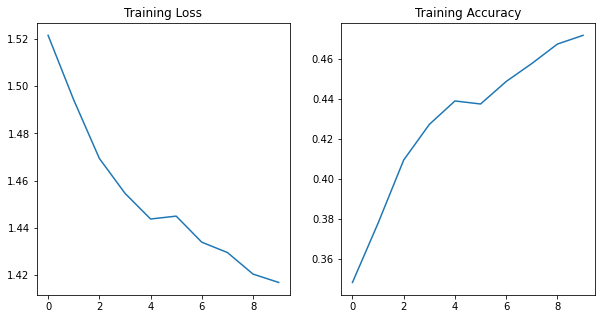

In [107]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_pos_encode_tanh)
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(train_acc_pos_encode_tanh)
plt.title("Training Accuracy")
plt.show()

In [108]:
model_pos_encode_tanh.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_pos_encode_tanh(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 5000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 5000 test images: 45 %


### Comparing the results

In [116]:
train_loss_pos_embeddings = np.load("train_loss_pos_embeddings.npy")
train_acc_pos_embeddings = np.load("train_acc_pos_embeddings.npy")

print(train_loss_pos_embeddings)
print(train_acc_pos_embeddings)

[1.54705377 1.48559843 1.47322383 1.46295253 1.45543146 1.45115852
 1.4468963  1.44218116 1.43872251 1.4332896 ]
[0.31448 0.38612 0.40592 0.41652 0.4262  0.42956 0.43116 0.44072 0.44512
 0.4496 ]


In [115]:
train_loss_pos_encode = np.load("train_loss_pos_encode.npy")
train_acc_pos_encode = np.load("train_acc_pos_encode.npy")

print(train_loss_pos_encode)
print(train_acc_pos_encode)

[1.53200681 1.48706131 1.47137532 1.45537891 1.44344023 1.4403491
 1.4298685  1.42427319 1.41619584 1.41371297]
[0.33404 0.37844 0.403   0.4244  0.43796 0.43888 0.45084 0.45504 0.46404
 0.46928]


In [118]:
print(train_loss_pos_embeddings_tanh)
print(train_acc_pos_embeddings_tanh)

[1.531736131833524, 1.4927051255897599, 1.4746779744722405, 1.45796737987168, 1.4445128459103254, 1.4353207349777222, 1.4252125122109238, 1.4239251802162247, 1.4202033518528452, 1.4131798768530086]
[0.34372 0.37344 0.40692 0.42264 0.4378  0.44944 0.46012 0.4598  0.46352
 0.47072]


In [119]:
print(train_loss_pos_encode_tanh)
print(train_acc_pos_encode_tanh)

[1.5215646539415633, 1.4941828548908234, 1.4693790011259975, 1.4545918642258158, 1.4436758336972217, 1.444903780611194, 1.4338268643739271, 1.4294602974336974, 1.4203078175077632, 1.4167749376929537]
[0.34808, 0.3778, 0.40944, 0.42728, 0.43904, 0.43752, 0.4488, 0.4578, 0.46756, 0.47192]


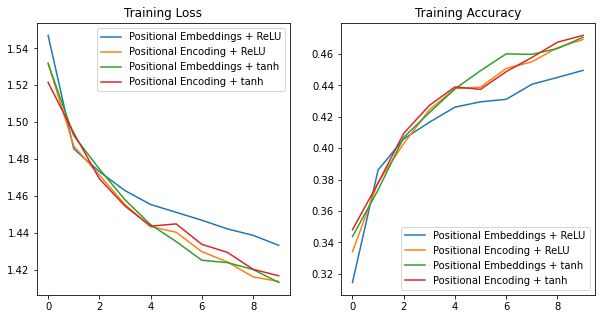

In [121]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_pos_embeddings, label="Positional Embeddings + ReLU")
plt.plot(train_loss_pos_encode, label="Positional Encoding + ReLU")
plt.plot(train_loss_pos_embeddings_tanh, label="Positional Embeddings + tanh")
plt.plot(train_loss_pos_encode_tanh, label="Positional Encoding + tanh")
plt.title("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_pos_embeddings, label="Positional Embeddings + ReLU")
plt.plot(train_acc_pos_encode, label="Positional Encoding + ReLU")
plt.plot(train_acc_pos_embeddings_tanh, label="Positional Embeddings + tanh")
plt.plot(train_acc_pos_encode_tanh, label="Positional Encoding + tanh")
plt.title("Training Accuracy")
plt.legend()
plt.show()

## Question 2

### Based on the lecture by Dr. Anush on DLOPs, we have to perform the following experiments:

### Load and preprocessing CIFAR10 dataset using standard augmentation and normalization techniques

In [2]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(  
    datasets.CIFAR10('data', train=True, download=True,
                        transform=train_transform),
    batch_size=128, shuffle=True) # 128 is the batch size

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=test_transform),
    batch_size=128, shuffle=False)  

X_train = train_loader.dataset.data # 50000 images
y_train = np.array(train_loader.dataset.targets) # 50000 labels
X_test = test_loader.dataset.data # 10000 images
y_test = np.array(test_loader.dataset.targets) # 10000 labels

classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

Files already downloaded and verified


In [3]:
def create_dataloader(x_train, y_train, x_test, y_test):
    x_train, x_test, y_train, y_test = torch.Tensor(x_train).permute(0, 3, 1, 2), torch.Tensor(x_test).permute(0, 3, 1, 2), torch.Tensor(y_train), torch.Tensor(y_test)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle = True)

    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle = False)

    return trainloader, testloader

trainloader, testloader = create_dataloader(X_train, y_train, X_test, y_test)

torch.Size([50000, 3, 32, 32]) torch.Size([50000]) torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Training the following models for profiling them using during the training step

    - Conv -> Conv -> Maxpool (2,2) -> Conv -> Maxpool(2,2) -> Conv -> Maxpool(2,2)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
cnn_model = CNN()
cnn_model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [7]:
import tensorboard
import torch_tb_profiler as tbp

In [8]:
def train_model(model, model_name):
    model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=50, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./logs/{model_name}'),
        record_shapes=False,
        profile_memory=False,
        with_stack=False
    ) as prof:

        stats = {'train': [], 'test': []}

        for epoch in range(10):
        
            # training the model
            model.train()
            correct, total = 0, 0
            running_loss = 0
            batch_counter = 0

            for (images, labels) in tqdm(train_loader):
                images = images.float().cuda()
                labels = labels.long().cuda()

                optimizer.zero_grad()
                outputs = model(images)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.shape[0]

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                loss.backward()
                optimizer.step()
                
                batch_counter += 1
                prof.step()

            print(f"Epoch: {epoch+1}, Train Loss: {running_loss/batch_counter}, Train Accuracy: {round(correct/total, 4)}")
            stats['train'].append({'loss': running_loss/batch_counter, 'accuracy': round(correct/total, 4)})
            
            # testing the model
            model.eval()
            correct, total = 0, 0
            running_loss = 0
            batch_counter = 0

            for (images, labels) in test_loader:
                images = images.float().cuda()
                labels = labels.long().cuda()

                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.shape[0]

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                batch_counter += 1
            
            print(f"Epoch: {epoch+1}, Test Loss: {running_loss/batch_counter}, Test Accuracy: {round(correct/total, 4)}")
            stats['test'].append({'loss': running_loss/batch_counter, 'accuracy': round(correct/total, 4)})
            print(" ")
    
    return stats

In [144]:
stats_cnn = train_model(cnn_model, 'cnn_model')

100%|██████████| 391/391 [01:15<00:00,  5.17it/s]


Epoch: 1, Train Loss: 1.5694767139147006, Train Accuracy: 0.4185
Epoch: 1, Test Loss: 1.2240579188624514, Test Accuracy: 0.5537
 


100%|██████████| 391/391 [00:20<00:00, 18.86it/s]


Epoch: 2, Train Loss: 1.139008178430445, Train Accuracy: 0.5922
Epoch: 2, Test Loss: 0.9864075817639315, Test Accuracy: 0.6473
 


100%|██████████| 391/391 [00:20<00:00, 19.20it/s]


Epoch: 3, Train Loss: 0.9260671343035101, Train Accuracy: 0.6724
Epoch: 3, Test Loss: 0.790056586265564, Test Accuracy: 0.7262
 


100%|██████████| 391/391 [00:20<00:00, 19.13it/s]


Epoch: 4, Train Loss: 0.7945665310106009, Train Accuracy: 0.7215
Epoch: 4, Test Loss: 0.7500615957417066, Test Accuracy: 0.7439
 


100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


Epoch: 5, Train Loss: 0.7210229296818413, Train Accuracy: 0.7462
Epoch: 5, Test Loss: 0.6576734898211081, Test Accuracy: 0.7766
 


100%|██████████| 391/391 [00:22<00:00, 17.50it/s]


Epoch: 6, Train Loss: 0.6609776976620755, Train Accuracy: 0.7672
Epoch: 6, Test Loss: 0.6275909422319147, Test Accuracy: 0.7846
 


100%|██████████| 391/391 [00:20<00:00, 19.12it/s]


Epoch: 7, Train Loss: 0.6154347982857843, Train Accuracy: 0.7847
Epoch: 7, Test Loss: 0.6663246147240265, Test Accuracy: 0.7751
 


100%|██████████| 391/391 [00:20<00:00, 19.16it/s]


Epoch: 8, Train Loss: 0.5739971953432274, Train Accuracy: 0.8005
Epoch: 8, Test Loss: 0.5685162155688563, Test Accuracy: 0.8061
 


100%|██████████| 391/391 [00:45<00:00,  8.54it/s]


Epoch: 9, Train Loss: 0.5441160349894667, Train Accuracy: 0.8082
Epoch: 9, Test Loss: 0.5379513011703009, Test Accuracy: 0.8132
 


100%|██████████| 391/391 [00:33<00:00, 11.82it/s]


Epoch: 10, Train Loss: 0.5190929659187337, Train Accuracy: 0.8188
Epoch: 10, Test Loss: 0.5508139578601982, Test Accuracy: 0.8104
 


 - VGG16

In [9]:
from torchvision import models
vgg_model = models.vgg16(pretrained=True).to(device)

In [10]:
torch.cuda.empty_cache()

In [11]:
stats_vgg_16 = train_model(vgg_model, 'vgg_model')

100%|██████████| 391/391 [02:11<00:00,  2.98it/s] 


Epoch: 1, Train Loss: 2.1697074421836287, Train Accuracy: 0.2131
Epoch: 1, Test Loss: 1.5474795238881172, Test Accuracy: 0.3596
 


100%|██████████| 391/391 [01:23<00:00,  4.67it/s]


Epoch: 2, Train Loss: 1.4015732524949875, Train Accuracy: 0.452
Epoch: 2, Test Loss: 1.0669517079486122, Test Accuracy: 0.5897
 


100%|██████████| 391/391 [01:23<00:00,  4.66it/s]


Epoch: 3, Train Loss: 1.0733815936176367, Train Accuracy: 0.6305
Epoch: 3, Test Loss: 0.9927021242395232, Test Accuracy: 0.6578
 


100%|██████████| 391/391 [01:24<00:00,  4.61it/s]


Epoch: 4, Train Loss: 0.8940036734351722, Train Accuracy: 0.7083
Epoch: 4, Test Loss: 0.7320887574666664, Test Accuracy: 0.7665
 


100%|██████████| 391/391 [01:24<00:00,  4.61it/s]


Epoch: 5, Train Loss: 0.7871910249790572, Train Accuracy: 0.7479
Epoch: 5, Test Loss: 0.6357861391351193, Test Accuracy: 0.7954
 


100%|██████████| 391/391 [01:24<00:00,  4.65it/s]


Epoch: 6, Train Loss: 0.7013016081679507, Train Accuracy: 0.7808
Epoch: 6, Test Loss: 0.6457263548162919, Test Accuracy: 0.8074
 


100%|██████████| 391/391 [01:24<00:00,  4.65it/s]


Epoch: 7, Train Loss: 0.671995295511792, Train Accuracy: 0.7901
Epoch: 7, Test Loss: 0.6093429210065286, Test Accuracy: 0.8113
 


100%|██████████| 391/391 [01:23<00:00,  4.66it/s]


Epoch: 8, Train Loss: 0.6226440493560508, Train Accuracy: 0.8064
Epoch: 8, Test Loss: 0.5588809542263611, Test Accuracy: 0.8339
 


100%|██████████| 391/391 [01:24<00:00,  4.65it/s]


Epoch: 9, Train Loss: 0.6065432282207567, Train Accuracy: 0.8132
Epoch: 9, Test Loss: 0.5740932433665553, Test Accuracy: 0.8215
 


100%|██████████| 391/391 [01:24<00:00,  4.65it/s]


Epoch: 10, Train Loss: 0.596957706581906, Train Accuracy: 0.818
Epoch: 10, Test Loss: 0.5905067600026915, Test Accuracy: 0.8188
 


### After the profiling of my models (CNN, VGG16), figuring out the minimum change in the architecture that would lead to a gain in performance and decrease training time on CIFAR10 dataset as compared to one achieved before.

- CNN updated

Replacing the fourth convolutional layer with a global average pooling layer. This modification can reduce the number of parameters in the model and prevent overfitting, thereby potentially improving its performance and reducing its training time.

The modified CNN_GAP model replaces the fourth convolutional layer with an adaptive average pooling layer (self.gap) with output size of (1, 1). This pooling layer averages the output feature maps from the third convolutional layer into a single feature vector for each input image. This feature vector is then passed through a fully connected layer (self.fc) to produce the final output predictions.

By replacing the fourth convolutional layer with a global average pooling layer, we can reduce the number of parameters in the model and prevent overfitting, which can lead to improved performance and reduced training time on the CIFAR10 dataset. However, it's important to note that the performance of the modified CNN_GAP model may vary depending on factors such as the learning rate, the choice of optimizer, and the size of the dataset.

In [12]:
class CNN_GAP(nn.Module):
    def __init__(self):
        super(CNN_GAP, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.gap(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [13]:
cnn_updated_model = CNN_GAP().to(device)

In [14]:
stats_cnn_updated = train_model(cnn_updated_model, 'cnn_updated_model')

100%|██████████| 391/391 [01:09<00:00,  5.59it/s]


Epoch: 1, Train Loss: 1.9107499701897506, Train Accuracy: 0.2748
Epoch: 1, Test Loss: 1.7623357380492777, Test Accuracy: 0.3319
 


100%|██████████| 391/391 [00:21<00:00, 18.56it/s]


Epoch: 2, Train Loss: 1.7206116951335118, Train Accuracy: 0.3532
Epoch: 2, Test Loss: 1.6754868754857704, Test Accuracy: 0.3788
 


100%|██████████| 391/391 [00:20<00:00, 18.87it/s]


Epoch: 3, Train Loss: 1.6390502132723093, Train Accuracy: 0.396
Epoch: 3, Test Loss: 1.6114480465273313, Test Accuracy: 0.4073
 


100%|██████████| 391/391 [00:20<00:00, 18.75it/s]


Epoch: 4, Train Loss: 1.5566253476130687, Train Accuracy: 0.4319
Epoch: 4, Test Loss: 1.4783561908746068, Test Accuracy: 0.46
 


100%|██████████| 391/391 [00:22<00:00, 17.65it/s]


Epoch: 5, Train Loss: 1.476162248865113, Train Accuracy: 0.4668
Epoch: 5, Test Loss: 1.4459361426437958, Test Accuracy: 0.4731
 


100%|██████████| 391/391 [00:21<00:00, 18.27it/s]


Epoch: 6, Train Loss: 1.4030611176624932, Train Accuracy: 0.4947
Epoch: 6, Test Loss: 1.384910455232934, Test Accuracy: 0.502
 


100%|██████████| 391/391 [00:22<00:00, 17.76it/s]


Epoch: 7, Train Loss: 1.3446208787391254, Train Accuracy: 0.5169
Epoch: 7, Test Loss: 1.3182998261874235, Test Accuracy: 0.5259
 


100%|██████████| 391/391 [00:21<00:00, 18.46it/s]


Epoch: 8, Train Loss: 1.2979120345371764, Train Accuracy: 0.5357
Epoch: 8, Test Loss: 1.3055485532253603, Test Accuracy: 0.5306
 


100%|██████████| 391/391 [00:21<00:00, 18.22it/s]


Epoch: 9, Train Loss: 1.2645497050736567, Train Accuracy: 0.5472
Epoch: 9, Test Loss: 1.2547452796863605, Test Accuracy: 0.5544
 


100%|██████████| 391/391 [00:20<00:00, 18.99it/s]


Epoch: 10, Train Loss: 1.2320791197859722, Train Accuracy: 0.5603
Epoch: 10, Test Loss: 1.223676873158805, Test Accuracy: 0.5625
 


- VGG16 Updated

Modifying the number of filters in each convolutional layer and adjust the number of neurons in the fully connected layers accordingly. Specifically, we can reduce the number of filters in each convolutional layer to reduce the number of parameters and speed up training, while maintaining the structure of the network.

Below is the modified VGG16 model that reduces the number of filters by a factor of 4

In [15]:
class VGG16_modified(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16_modified, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )
        
        # Modify the number of filters in the convolutional layers
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                m.out_channels = m.out_channels // 4
        
        # Initialize the weights of the modified convolutional layers
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [17]:
vgg_model_updated = VGG16_modified().to(device)

In [18]:
stats_vgg_16_updated = train_model(vgg_model_updated, 'vgg_modified_model')

100%|██████████| 391/391 [01:25<00:00,  4.57it/s] 


Epoch: 1, Train Loss: 2.1899139957354805, Train Accuracy: 0.1321
Epoch: 1, Test Loss: 1.823099803320969, Test Accuracy: 0.2597
 


100%|██████████| 391/391 [00:47<00:00,  8.29it/s]


Epoch: 2, Train Loss: 1.5524401210458076, Train Accuracy: 0.3639
Epoch: 2, Test Loss: 1.3104958534240723, Test Accuracy: 0.4741
 


100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


Epoch: 3, Train Loss: 1.2133773781759354, Train Accuracy: 0.5318
Epoch: 3, Test Loss: 1.0064334401601478, Test Accuracy: 0.6217
 


100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


Epoch: 4, Train Loss: 1.0293773194713056, Train Accuracy: 0.6252
Epoch: 4, Test Loss: 0.8169111390657062, Test Accuracy: 0.7342
 


100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


Epoch: 5, Train Loss: 0.8595015923385425, Train Accuracy: 0.7186
Epoch: 5, Test Loss: 0.8262006391452837, Test Accuracy: 0.7168
 


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


Epoch: 6, Train Loss: 0.7723152592511433, Train Accuracy: 0.7516
Epoch: 6, Test Loss: 0.6661269725123539, Test Accuracy: 0.7857
 


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


Epoch: 7, Train Loss: 0.7014544092480789, Train Accuracy: 0.7756
Epoch: 7, Test Loss: 0.6631886031054244, Test Accuracy: 0.7896
 


100%|██████████| 391/391 [00:48<00:00,  8.11it/s]


Epoch: 8, Train Loss: 0.6767981701037463, Train Accuracy: 0.7897
Epoch: 8, Test Loss: 0.6194440194323093, Test Accuracy: 0.8078
 


100%|██████████| 391/391 [00:48<00:00,  7.98it/s]


Epoch: 9, Train Loss: 0.6448498313384288, Train Accuracy: 0.7977
Epoch: 9, Test Loss: 0.6220460466191738, Test Accuracy: 0.8088
 


100%|██████████| 391/391 [00:49<00:00,  7.93it/s]


Epoch: 10, Train Loss: 0.6179656517475157, Train Accuracy: 0.8057
Epoch: 10, Test Loss: 0.6099210415459886, Test Accuracy: 0.805
 


**END OF ASSIGNMENT**